# Телеком

### Описание проекта:

Для оператора связи "ТелеДом" требуется создать модель предсказывающую разрыв договора с клиентом.

### Описание услуг   

Два основных типа услуг:
* Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
* Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).

Дополнительный ряд услуг:

* Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
* Выделенная линия технической поддержки (Tech Support);
* Облачное хранилище файлов для резервного копирования данных (Online Backup);
* Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).

### Описание базы данных

Данные представлены следующими таблицами:

* contract — информация о договорах;
* personal — персональные данные клиентов;
* internet — информация об интернет-услугах;
* phone — информация об услугах телефонии.

### Задача:

Найти наилучшую модель для прогноза оттока клиентов со значением метрики ROC-AUC на тестовой выборке не менее 0.85%

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

import phik
from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix
import itertools


"""import torch
import torch.nn as nn
import transformers"""

"""import tensorflow.keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping"""

from sklearn.metrics import accuracy_score, auc,confusion_matrix,roc_curve, roc_auc_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from catboost import CatBoostClassifier, Pool
from catboost.utils import get_roc_curve
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


from sqlalchemy import create_engine

# theme
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

from numpy.random import RandomState
rs = RandomState(160424)
RANDOM_STATE = 160424

### Импорт таблиц из PostgreSQL

Импортировать и рассматривать та

In [2]:

db_config = {
'user': 'praktikum_student',# имя пользователя,
'pwd': 'Sdf4$2;d-d30pp',# пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,# порт подключения,
'db': 'data-science-final'# название базы данных,
}


In [3]:
connecting_string = 'postgresql://{}:{}@{}:{}/{}'.format(
db_config['user'],
db_config['pwd'],
db_config['host'],
db_config['port'],
db_config['db'])

In [4]:
engine = create_engine(connecting_string)

#### Contract

In [5]:
query = '''
SELECT *
FROM telecom.contract
'''

In [6]:
variables = []

In [7]:
contract = pd.read_sql_query(query, con = engine)
variables.append(['contract','query','engine','connecting_string','db_config'])

In [8]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Присутствуют пропуски в целевой переменной и незначительное количество в общей оплате услуг.

In [9]:
contract.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15


#### Personal

In [10]:
query = '''
SELECT *
FROM telecom.personal
'''

In [11]:
personal = pd.read_sql_query(query, con = engine)
variables.append('personal')

In [12]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [13]:
personal.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


#### Internet

In [14]:
query = '''
SELECT *
FROM telecom.internet;
'''

In [15]:
internet = pd.read_sql_query(query, con = engine)
variables.append('internet')

In [16]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518 entries, 0 to 5517
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      5518 non-null   object
 1   c2      5518 non-null   object
 2   c3      5518 non-null   object
 3   c4      5518 non-null   object
 4   c5      5518 non-null   object
 5   c6      5518 non-null   object
 6   c7      5518 non-null   object
 7   c8      5518 non-null   object
dtypes: object(8)
memory usage: 345.0+ KB


In [17]:
internet.head(3)

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No


Перенесём названия столбцов с первой строки:

In [18]:
internet.columns = internet.iloc[0]
internet = internet.drop(0).reset_index(drop = True)

display(internet.head(1))

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No


#### Phone

In [19]:
query = '''
SELECT *
FROM telecom.phone
'''

In [20]:
phone = pd.read_sql_query(query, con = engine)
variables.append('phone')


In [21]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362 entries, 0 to 6361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      6362 non-null   object
 1   c2      6362 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [22]:
phone.head(3)

,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No


Перенесём названия столбцов с первой строки:

In [23]:
phone.columns = phone.iloc[0]
phone = phone.drop(0).reset_index(drop = True)

## EDA

### Duplicated

Проверим полные дубликаты столбцов и скрытые дубликаты на уникальный ID пользователя:

In [24]:
print('internet dupli :',internet.duplicated().sum())
print('contract dupli :',contract.duplicated().sum())
print('personal dupli :',personal.duplicated().sum())
print('phone dupli :', phone.duplicated().sum())
print('\n')
print('internet customerID duplic:', internet['customerID'].duplicated().sum())
print('contract customerID duplic:', contract['customerID'].duplicated().sum())
print('personal customerID duplic:', personal['customerID'].duplicated().sum())
print('phone customerID duplic:', phone['customerID'].duplicated().sum())

internet dupli : 0
contract dupli : 0
personal dupli : 0
phone dupli : 0


internet customerID duplic: 0
contract customerID duplic: 0
personal customerID duplic: 0
phone customerID duplic: 0


### Скрытые дубликаты в object и пропуски

In [25]:
def d_h(data):
    display(data.describe(include = 'all'))

In [26]:
d_h(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [27]:
d_h(phone)

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


In [28]:
d_h(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,1869,7043,7043,7043,7043.000000,7032.000000
unique,7043,515,4,3,2,4,NaN,NaN
top,4472-LVYGI,2019-03-24,2019-11-01,Month-to-month,Yes,Electronic check,NaN,NaN
freq,1,43,485,3875,4171,2365,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,2283.300441
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,2266.771362
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,18.800000
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,401.450000
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,1397.475000
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,3794.737500


Просмотрим столбцы с категориальными признаками :

In [29]:
for i in ['Type','PaymentMethod']:
    display(contract[i].unique())

array(['Two year', 'Month-to-month', 'One year'], dtype=object)

array(['Bank transfer (automatic)', 'Mailed check', 'Electronic check',
       'Credit card (automatic)'], dtype=object)

Посмотрим пропуски в TotalCharges:

In [30]:
contract[contract['TotalCharges'].isna() == True].head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,NaN


* Пропуски в TotalCharges соответствуют клиентам подключившим тариф в месяц актуализации набора данных, с оплатой на год-два. Их общие траты ещё не рассчитаны.
* Исходя из этого столбца, получается, данные итоговых расходов не включают(Или могут не включать) текущий, оплаченный период. 

In [31]:
d_h(personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


### Внутренняя обработка данных, создание новых признаков, графики статистик

#### INTERNET

Превратим object в бинарный вид:

In [32]:
for x in internet.columns[-6:]:
    internet[f'{x}'] = internet[f'{x}'].apply( lambda x: 1 if x == 'Yes' else 0 )

In [33]:
internet.head(2)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,0,1,0,0,0,0
1,5575-GNVDE,DSL,1,0,1,0,0,0


Создадим отдельный столбец, обозначающий использование клиентом дополнительных услуг:

In [34]:
internet['UseServices'] = 0
for i in internet.columns[2:]:   
     internet['UseServices'] += internet[f'{i}'].astype(bool)
internet['UseServices'] = (internet['UseServices'].astype(bool)).astype(int)

internet['ServicesCount'] = 0
for i in internet.columns[2:-2]:   
     internet['ServicesCount'] += internet[f'{i}'].astype(bool)
internet['ServicesCount'] = internet['ServicesCount'].astype(int)

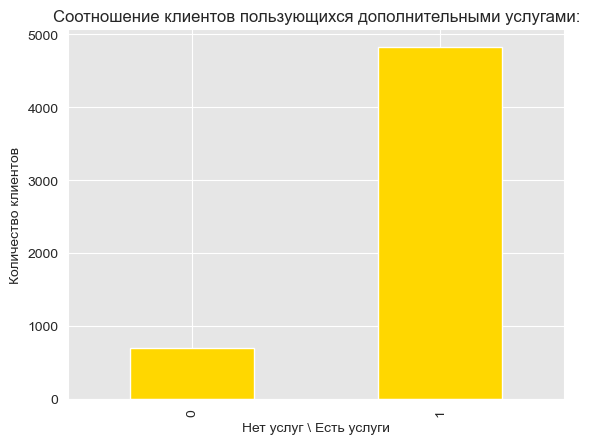

In [35]:
internet.groupby('UseServices')['UseServices'].count().plot(kind = 'bar', color = 'gold')
plt.title('Соотношение клиентов пользующихся дополнительными услугами:')
plt.ylabel('Количество клиентов')
plt.xlabel('Нет услуг \ Есть услуги');

* Большинство клиентов заинтересованно в использовании дополнительных услуг

#### PHONE

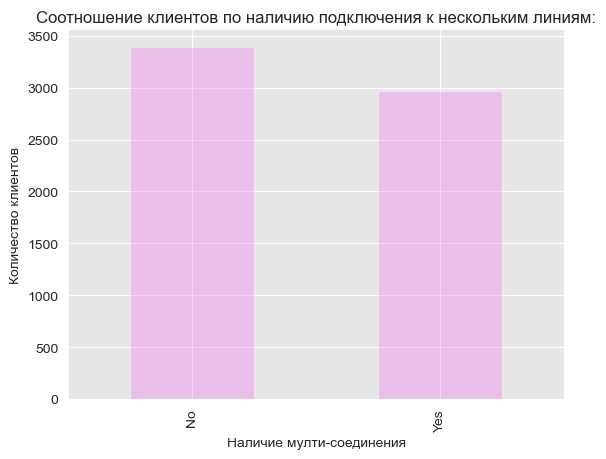

In [36]:
phone.groupby('MultipleLines')['MultipleLines'].count().plot(kind = 'bar', color = ['violet'], alpha = 0.4)
plt.title('Соотношение клиентов по наличию подключения к нескольким линиям:')
plt.ylabel('Количество клиентов')
plt.xlabel('Наличие мулти-соединения');

Закодируем переменную не как бинарную, а как категориальную значениями [1,2] чтобы модель видела эти значения как разные по значимости веса, а при слиянии таблиц, для клиентов не обладающих телефнной линией присвоим 0, что будет эквивалентно маркеру наличия и отсутствия телефонной линии

In [37]:
phone['MultipleLines'] = phone['MultipleLines'].apply( lambda x: 2 if x == "Yes" else 1)

#### PERSONAL

In [38]:
for x in personal.columns[-2:]:
    personal[f'{x}'] = personal[f'{x}'].apply(lambda x:1 if x == "Yes" else 0)

In [39]:
print('Самый частый портрет клиента:')
personal.loc[:,list(personal.columns[1:])].mode()

Самый частый портрет клиента:


,gender,SeniorCitizen,Partner,Dependents
0,Male,0,0,0


#### CONTRACT

In [40]:
contract['PaperlessBilling'] = contract['PaperlessBilling'].apply( lambda x: 1 if x == "Yes" else 0)

In [41]:
contract.head(2)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,1,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,0,Mailed check,20.25,NaN


Копируем дату отключения клиента в отдельный столбец, который будет таргетом.

In [42]:
contract['Target'] = contract['EndDate']

EndDate временно оставим для дальнейшего создания признаков.

Переведём время в специальный формат

In [43]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])

In [44]:
contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors = 'coerce') # игнорируем ошибки

Посмотрим уникальные даты отключения тарифа:

In [45]:
contract['EndDate'].value_counts()

2019-11-01    485
2019-12-01    466
2020-01-01    460
2019-10-01    458
Name: EndDate, dtype: int64

Text(0, 0.5, 'Количество клиентов')

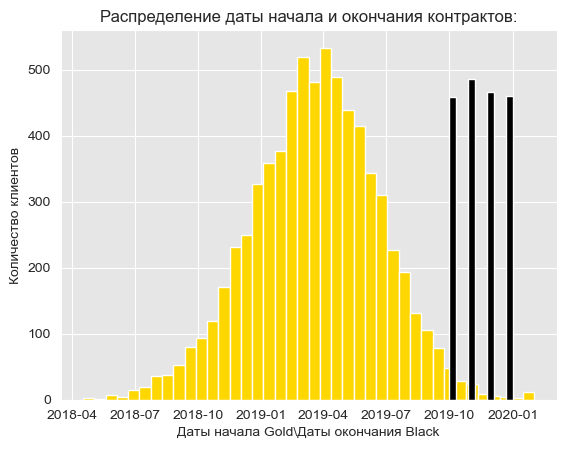

In [46]:
contract['BeginDate'].hist(bins = 40, color = 'gold')
contract['EndDate'].hist(bins = 10, color = 'black')
plt.title('Распределение даты начала и окончания контрактов:')
plt.xlabel('Даты начала Gold\Даты окончания Black')
plt.ylabel('Количество клиентов')

Заполним пропуски в дате окончания договора днем актульности данных, чтобы посчитатьть количество дей, которое клиент пользуется услугами:

In [47]:
contract['EndDate'].fillna('2020-02-01', inplace = True)

Считаем дни использования тарифа:

In [48]:
contract['UseDay'] = ((contract['EndDate'] - contract['BeginDate'])/ np.timedelta64(1,'D') +1 ).astype(int)
contract['UseMonth'] = ((contract['EndDate'] - contract['BeginDate'])/ np.timedelta64(1,'M') +1 ).astype(int)

Создаём целевой признак:

In [49]:
contract['Target'] = (contract['Target'].astype(bool)).astype(int)

Построим гистограмму распределения ушедших и контрактных клиентов:

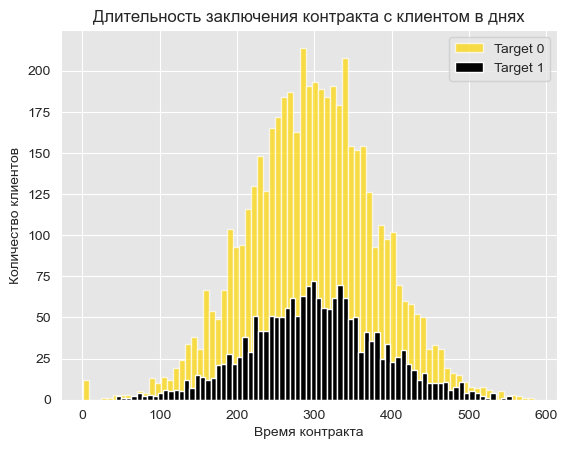

In [50]:
contract[contract['Target'] == 0]['UseDay'].rename('Target 0').hist(bins = 75, color = 'gold', alpha = 0.7, legend = True)
contract[contract['Target'] == 1]['UseDay'].rename('Target 1').hist(bins = 75,color = 'black',legend = True)
plt.title('Длительность заключения контракта с клиентом в днях')
plt.xlabel('Время контракта')
plt.ylabel('Количество клиентов');


* Оба распределения нормальны, что В ДАННОМ виде показывает скорее независимость оттока клиентов от сроков использования тарифами.
* Гистограмма может не нести за собой правдоподобия ввиду обозначенного выше отсутствия уникальности и размаха дат отключения. 

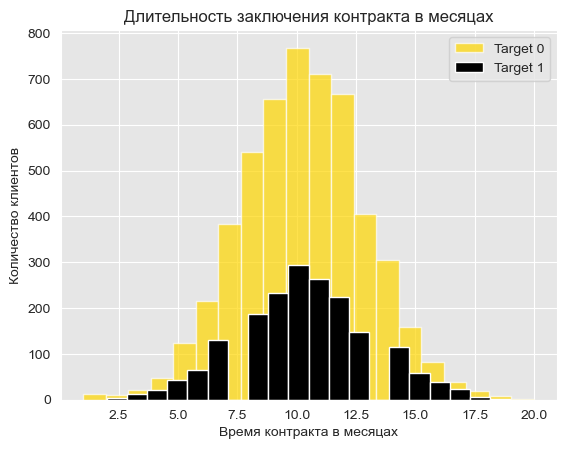

In [51]:
contract[contract['Target'] == 0]['UseMonth'].rename('Target 0').hist(bins = 20, color = 'gold', alpha = 0.7, legend = True)
contract[contract['Target'] == 1]['UseMonth'].rename('Target 1').hist(bins = 20,color = 'black',legend = True)
plt.title('Длительность заключения контракта в месяцах')
plt.xlabel('Время контракта в месяцах')
plt.ylabel('Количество клиентов');


In [52]:
(contract['BeginDate'] > contract['EndDate']).sum()

0

* В гистограммах распределения по месяцам наблюдается отстутствующие значения для клиентов разорвавших договор с компанией. Вероятно, эти пропуски так же связаны с одинаковыми датами таргета.

**Создадим столбец описывающий количество месяцев на которые клиент оплатил тариф**

In [53]:
def type_to_int(data):
    if data == 'Month-to-month':
        return 1
    elif data == 'Two year':
        return 24
    elif data == 'One year':
        return 12

In [54]:
contract['Type_count'] = contract['Type'].apply(type_to_int)

**Заполним пропуски в TotalCharget**

In [55]:
contract[contract['TotalCharges'].isna() == True]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,UseDay,UseMonth,Type_count
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,1,Bank transfer (automatic),52.55,NaN,0,1,1,24
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,0,Mailed check,20.25,NaN,0,1,1,24
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,0,Mailed check,80.85,NaN,0,1,1,24
6,4367-NUYAO,2020-02-01,2020-02-01,Two year,0,Mailed check,25.75,NaN,0,1,1,24
7,1371-DWPAZ,2020-02-01,2020-02-01,Two year,0,Credit card (automatic),56.05,NaN,0,1,1,24
9,3213-VVOLG,2020-02-01,2020-02-01,Two year,0,Mailed check,25.35,NaN,0,1,1,24
10,2923-ARZLG,2020-02-01,2020-02-01,One year,1,Mailed check,19.70,NaN,0,1,1,12
11,2775-SEFEE,2020-02-01,2020-02-01,Two year,1,Bank transfer (automatic),61.90,NaN,0,1,1,24
4408,7644-OMVMY,2020-02-01,2020-02-01,Two year,0,Mailed check,19.85,NaN,0,1,1,24
5160,2520-SGTTA,2020-02-01,2020-02-01,Two year,0,Mailed check,20.00,NaN,0,1,1,24


* Пропуски в TotalCharges соответствуют клиентам подключившим тариф в месяц актуализации набора данных, с оплатой на год-два. Их общие траты ещё не рассчитаны.
* Исходя из этого столбца, получается, данные итоговых расходов не включают(Или могут не включать) текущий, оплаченный период.
* Ввиду ситуации выше: TotalCharges -это признак-кандидат на удаление.

Заполнение пропуска рассчетом:

In [56]:
for x in list(contract[contract['TotalCharges'].isna() == True].index):
    contract.loc[x,['TotalCharges']] = int(contract.loc[x,['Type_count']]) * float(contract.loc[x,['MonthlyCharges']])

In [57]:
contract.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,UseDay,UseMonth,Type_count
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,1,Bank transfer (automatic),52.55,1261.20,0,1,1,24
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,0,Mailed check,20.25,486.00,0,1,1,24
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,480,16,1


###  Объединение dataframe и общая корреляция

### Объединение dataframe

In [58]:
data = pd.merge(contract,phone, how = 'outer', on = 'customerID')
data = pd.merge(data, internet, how = 'outer', on = 'customerID')
data = pd.merge(data, personal, how = 'outer',on = 'customerID')
variables.append('data')

~~Удалим 11 строк с пропусками в TotalCharges~~

In [60]:
contract.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,UseDay,UseMonth,Type_count
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,1,Bank transfer (automatic),52.55,1261.20,0,1,1,24
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,0,Mailed check,20.25,486.00,0,1,1,24
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,480,16,1


## Просмотр и обработка итогового DataFrame:

Удалим признаки, которые, не пригодятся в будущем.

In [62]:
delite_columns = ['customerID','BeginDate','EndDate']
data = data.drop(columns = delite_columns)

**Рассмотрим месячный объем выплат клиентов:**

MINIMUM: 18.25 MAXIMUM: 118.75


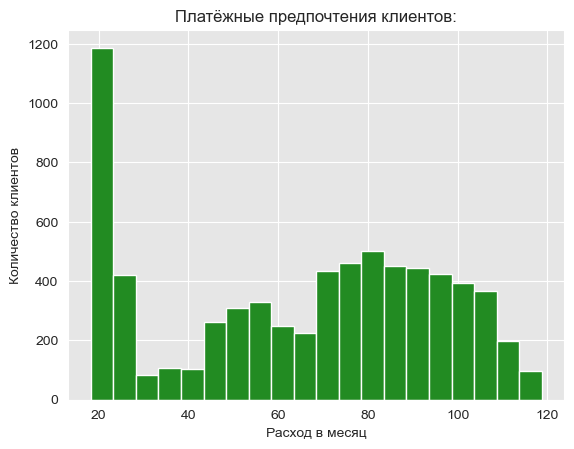

In [63]:
data['MonthlyCharges'].hist(bins = 20, color = 'forestgreen')
plt.title('Платёжные предпочтения клиентов:')
plt.xlabel('Расход в месяц')
plt.ylabel('Количество клиентов');

print('MINIMUM:',data['MonthlyCharges'].min(),'MAXIMUM:', data['MonthlyCharges'].max())

Не смотря на пик в минимальной планке оплаты - большой объем клиентов сосредоточен в большем ценовом диапозоне.

**Назначим категории для разных объемов месячной платы**

In [64]:
def pay_category(data):
    if data <= 25:
        return 'F 0-25'
    if data <= 40:
        return 'E 26-40'
    if data <= 55:
        return 'C 41-55'
    if data <= 70:
        return 'D 56-70'
    if data <= 85:
        return 'B 71-85'
    if data <= 100:
        return 'A 86-100'
    if data > 100:
        return 'S 101+'

In [65]:
data['Pay_category'] = data['MonthlyCharges'].apply(pay_category)

**Сравним объем оттока клиентов с их месячной платой по категориям**

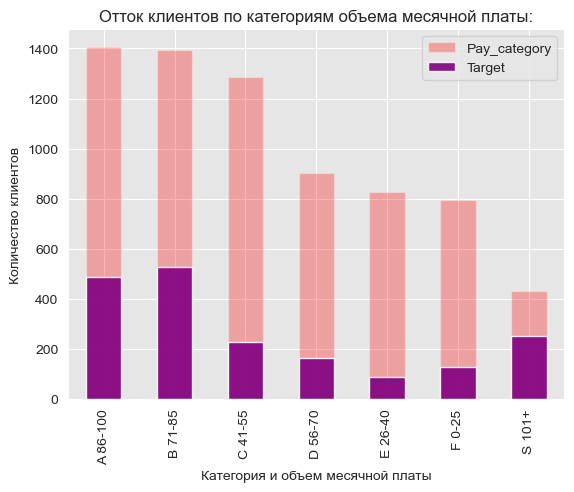

In [66]:
data['Pay_category'].value_counts().plot(kind = 'bar', color = 'red', alpha = 0.3, legend = True)
data.groupby('Pay_category')['Target'].agg('sum').plot(kind = 'bar', legend = True,color = 'purple', alpha = 0.9)
plt.title('Отток клиентов по категориям объема месячной платы:')
plt.xlabel('Категория и объем месячной платы')
plt.ylabel('Количество клиентов');

Наибольший отток приходится на клиентов с 'дорогими' тарифами.

**Сравм отток клиентов с количеством используемых услуг** 

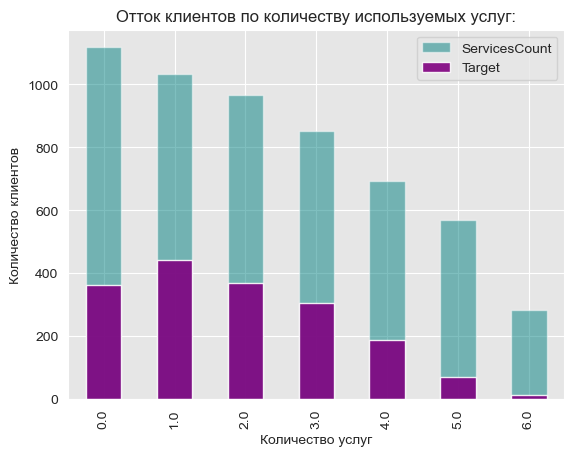

In [67]:
data['ServicesCount'].value_counts().plot(kind = 'bar', color = 'teal', alpha = 0.5, legend = True)
data.groupby('ServicesCount')['Target'].agg('sum').plot(kind = 'bar', legend = True,color = 'purple', alpha = 0.9)
plt.title('Отток клиентов по количеству используемых услуг:')
plt.xlabel('Количество услуг')
plt.ylabel('Количество клиентов');

### Обработка образовавшихся пропусков:

In [68]:
data.isna().sum()

Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Target                 0
UseDay                 0
UseMonth               0
Type_count             0
MultipleLines        682
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
UseServices         1526
ServicesCount       1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
Pay_category           0
dtype: int64

Создадим списки переменных:

In [69]:
cat_col = ['PaymentMethod','InternetService','Pay_category','Type','MultipleLines']

# заполним категориальные переменные новой категорией:
for i in cat_col:
    data[f'{i}'].fillna('NA', inplace = True)
    data[f'{i}'] = data[f'{i}'].apply(lambda x: str(x))

# Для этой категории отдельно закодируем 0 как отсутствие телефонной линии 
data['MultipleLines'].fillna(0, inplace = True)

num_col = ['MonthlyCharges','TotalCharges','UseDay']


bin_col = ['PaperlessBilling','gender','SeniorCitizen','Partner','Dependents','OnlineSecurity',
          'OnlineBackup','DeviceProtection','TechSupport','StreamingTV',
          'StreamingMovies','UseServices']
# Бинарные категории нулём:
for i in bin_col:
    data[f'{i}'].fillna( 'NA' , inplace = True)
    data[f'{i}'] = data[f'{i}'].apply(lambda x: str(x))

### Отток клиентов в объеме каждого признака:

#### Категории:

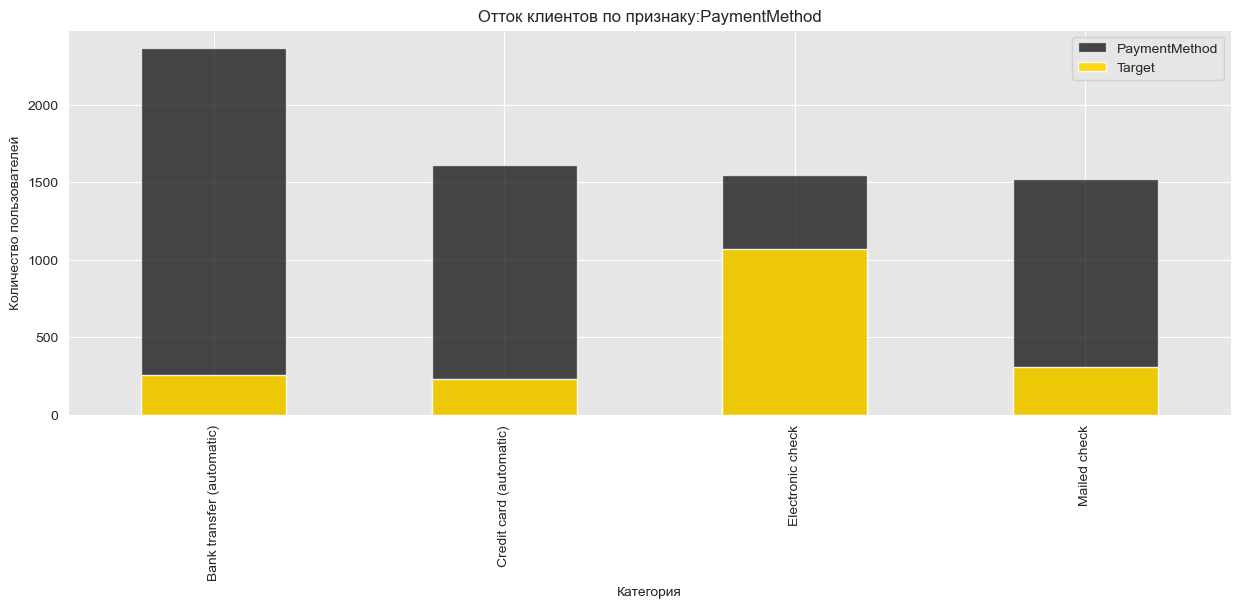

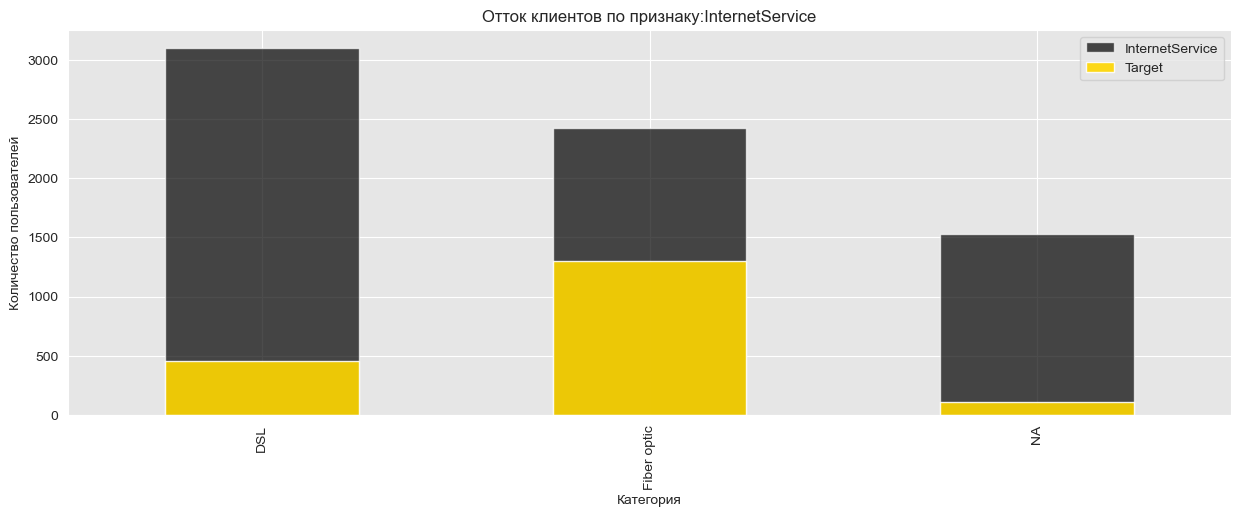

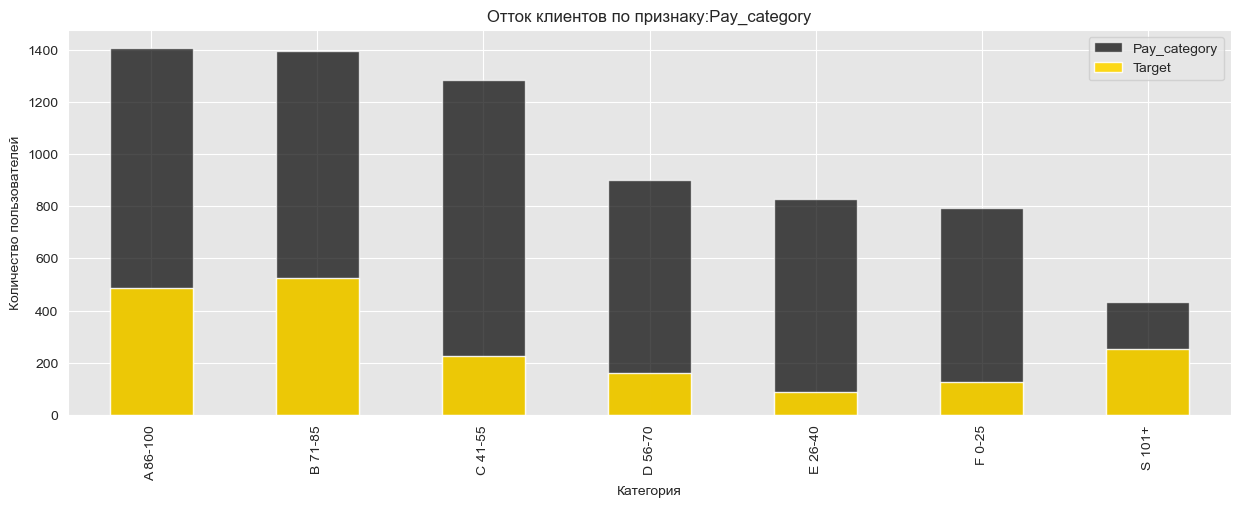

In [70]:
for i in cat_col[:-2]:
    plt.figure(figsize=(15,5))
    data[f'{i}'].value_counts().plot(kind = 'bar', color = 'black', alpha = 0.7, legend = True)
    data.groupby(f'{i}')['Target'].agg('sum').plot(kind = 'bar', legend = True,color = 'gold', alpha = 0.9)
    plt.ylabel('Количество пользователей')
    plt.xlabel('Категория')
    plt.title(f'Отток клиентов по признаку:{i}')
    plt.show();

#### Бинарные признаки:

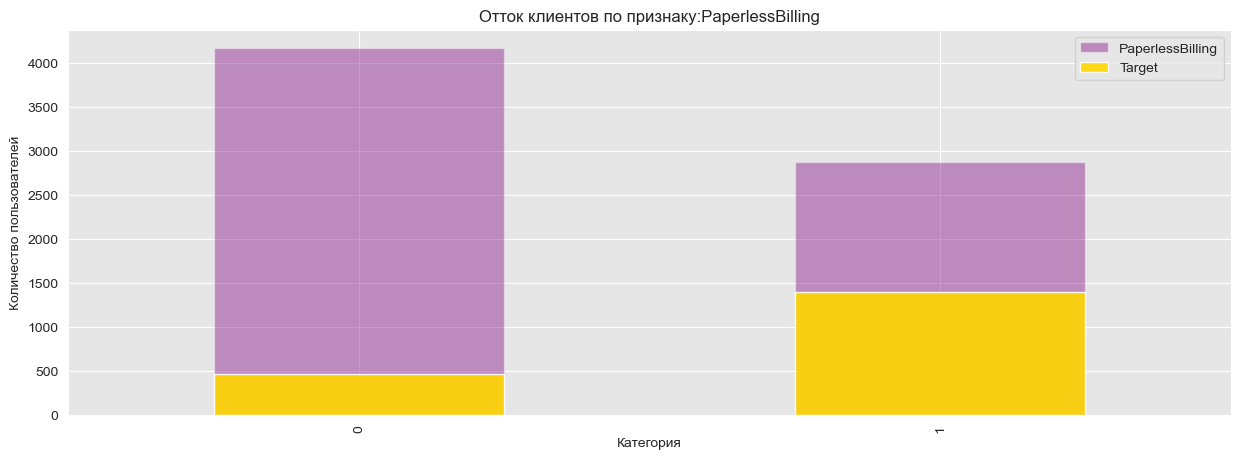

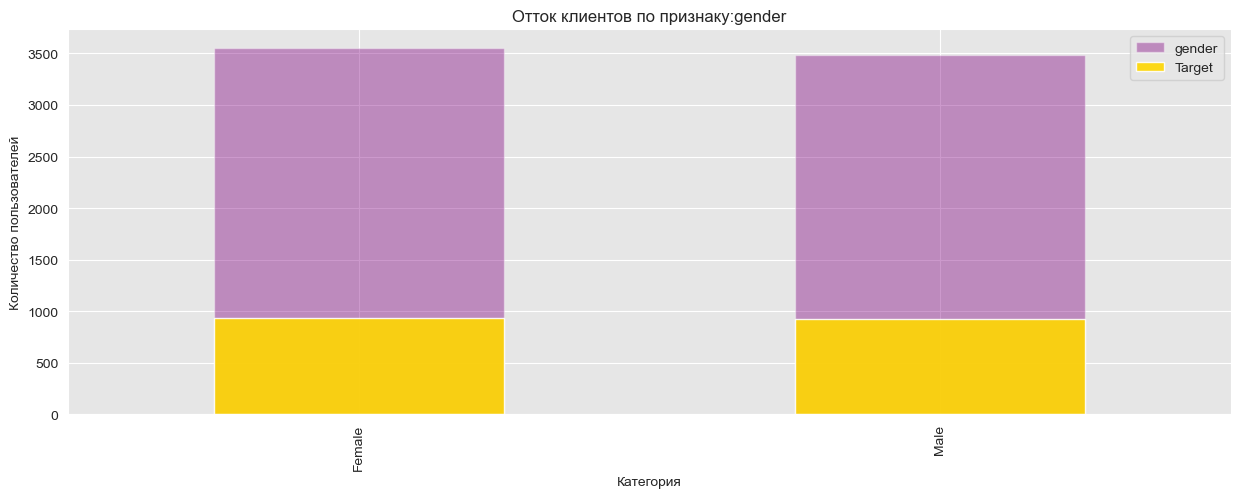

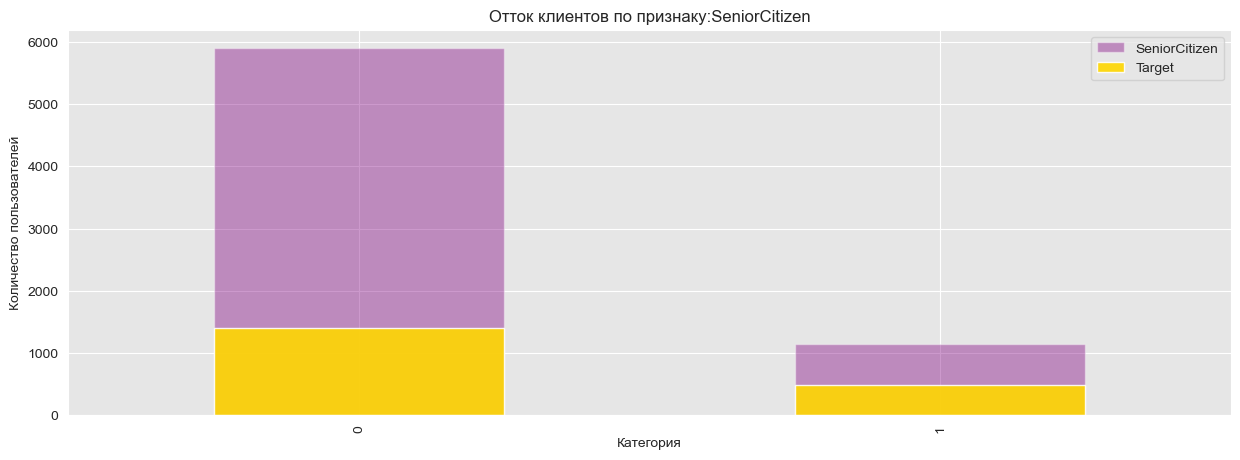

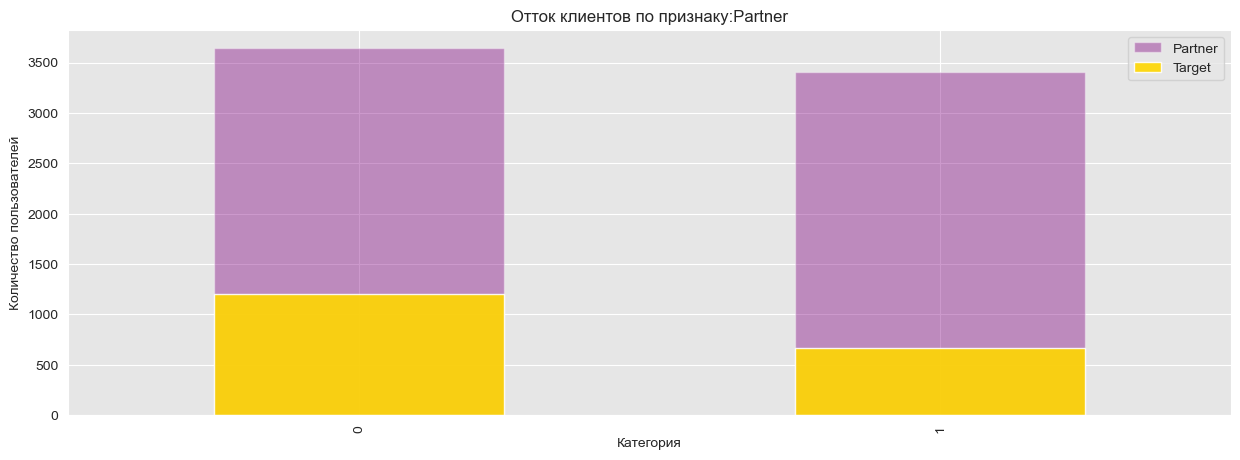

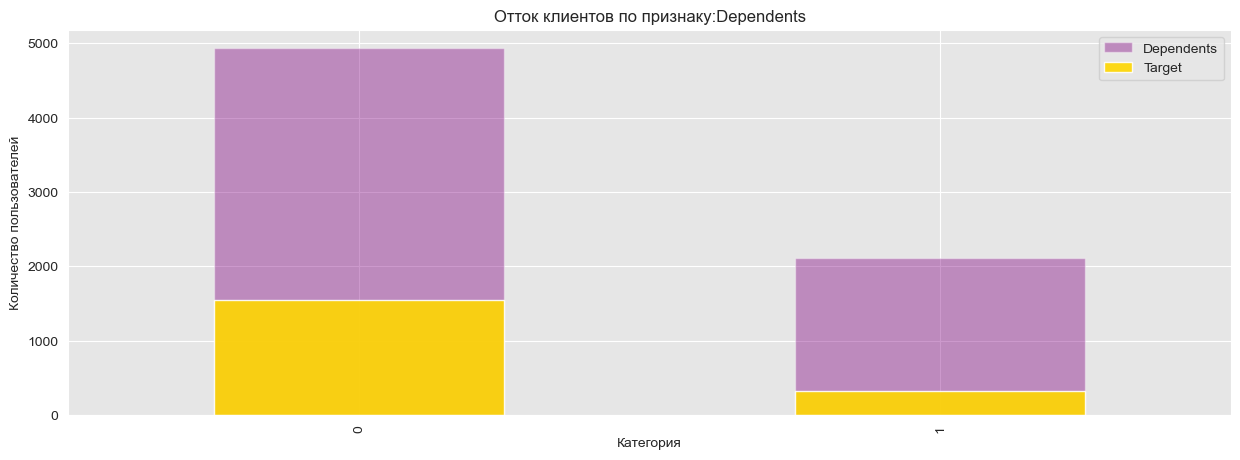

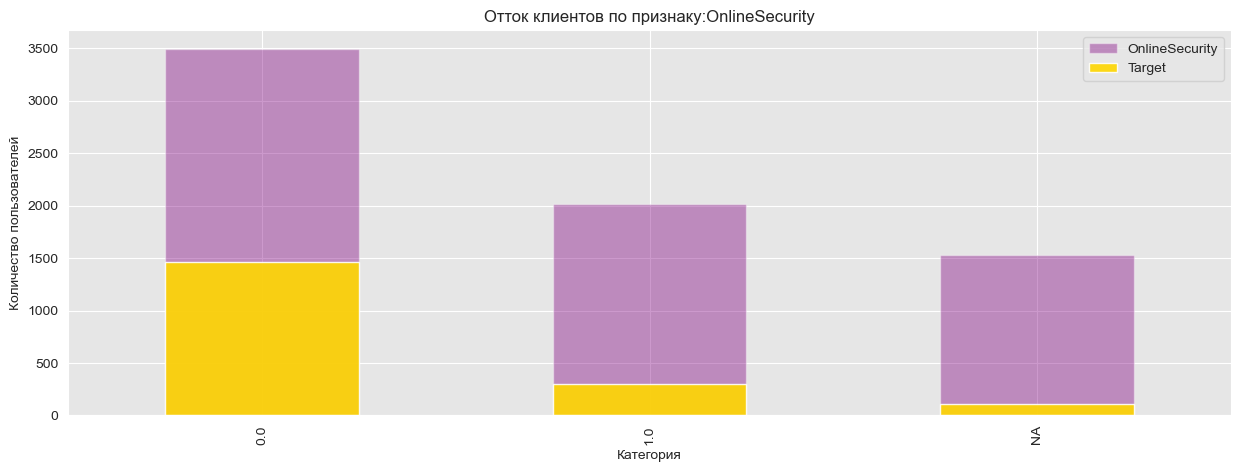

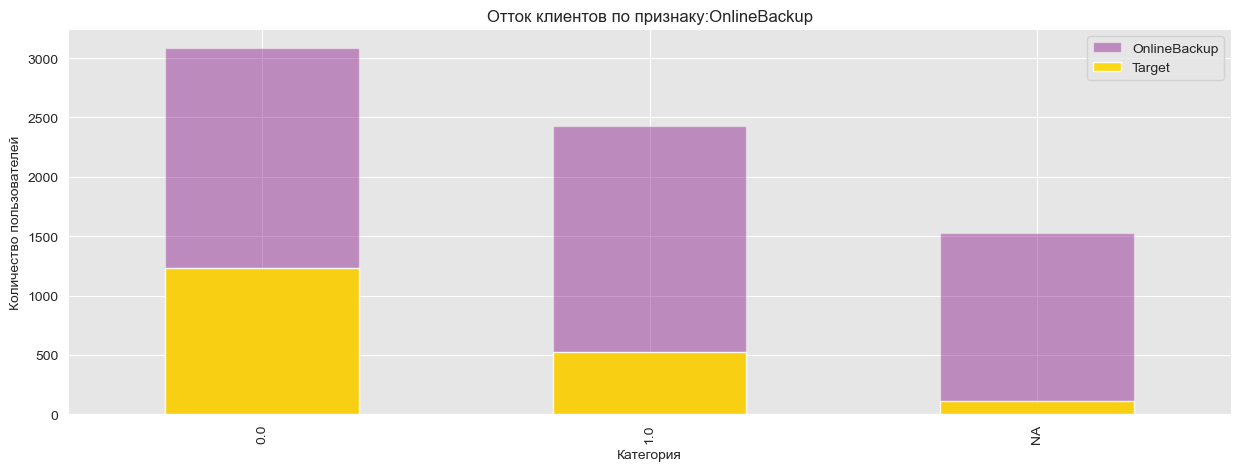

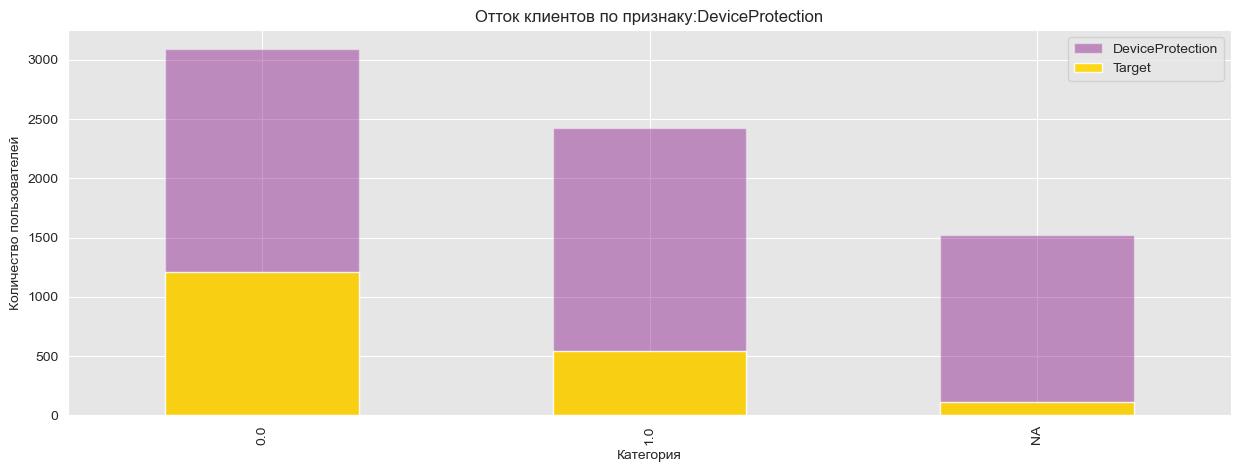

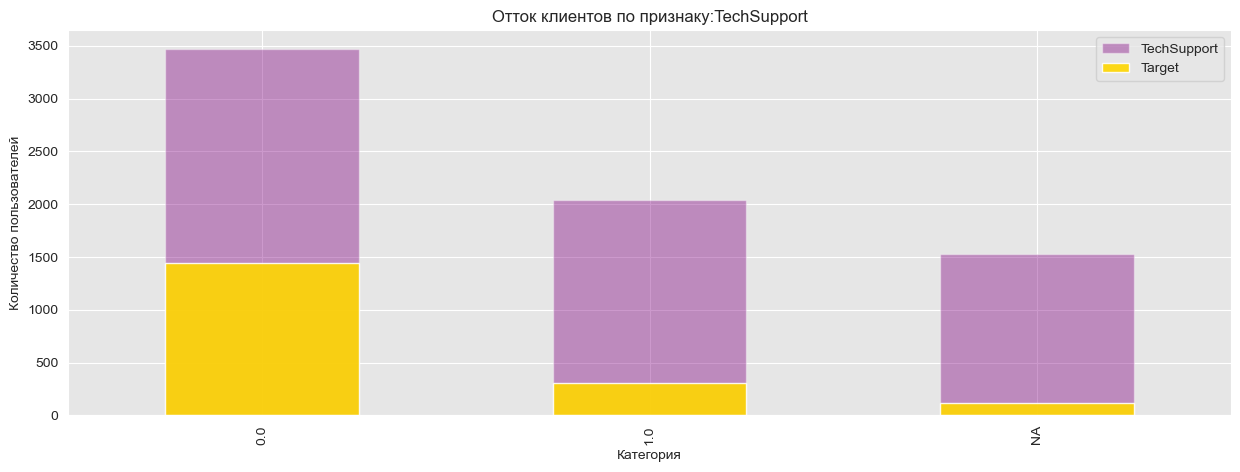

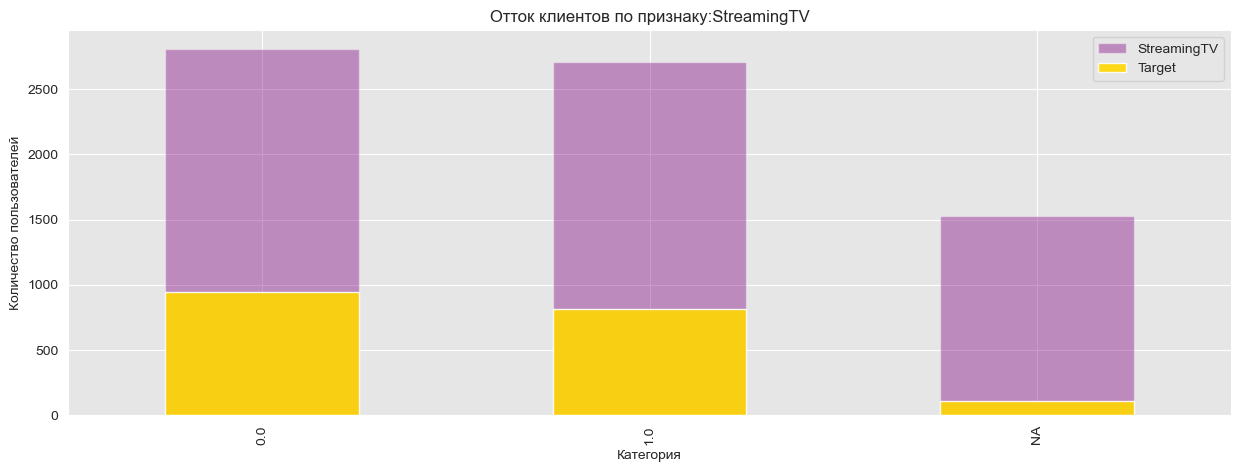

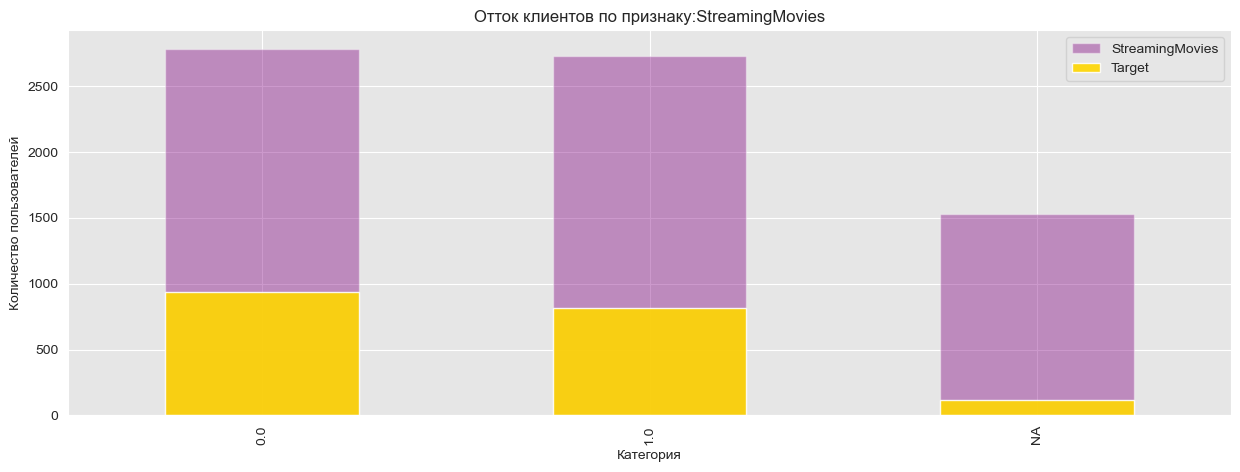

In [71]:
for i in bin_col[:-1]:
    plt.figure(figsize=(15,5))
    data[f'{i}'].value_counts().plot(kind = 'bar', color = 'purple', alpha = 0.4, legend = True)
    data.groupby(f'{i}')['Target'].agg('sum').plot(kind = 'bar', legend = True,color = 'gold', alpha = 0.9)
    plt.ylabel('Количество пользователей')
    plt.xlabel('Категория')
    plt.title(f'Отток клиентов по признаку:{i}')
    plt.show();

Зависимость целевой переменной от пола показывает сомнительную, а визуально - мнимальную зависимость, на уровне шума. Удалим этот признак 

#### Количественные признаки

<Figure size 1500x500 with 0 Axes>

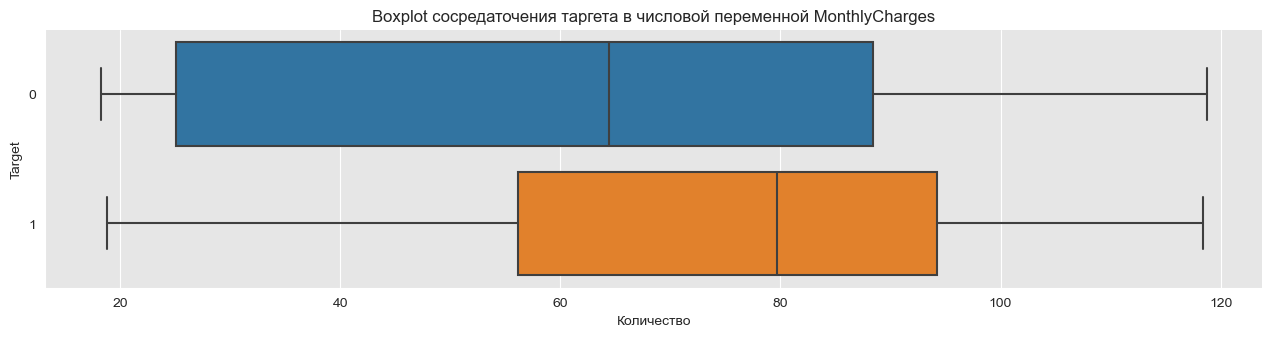

<Figure size 1500x500 with 0 Axes>

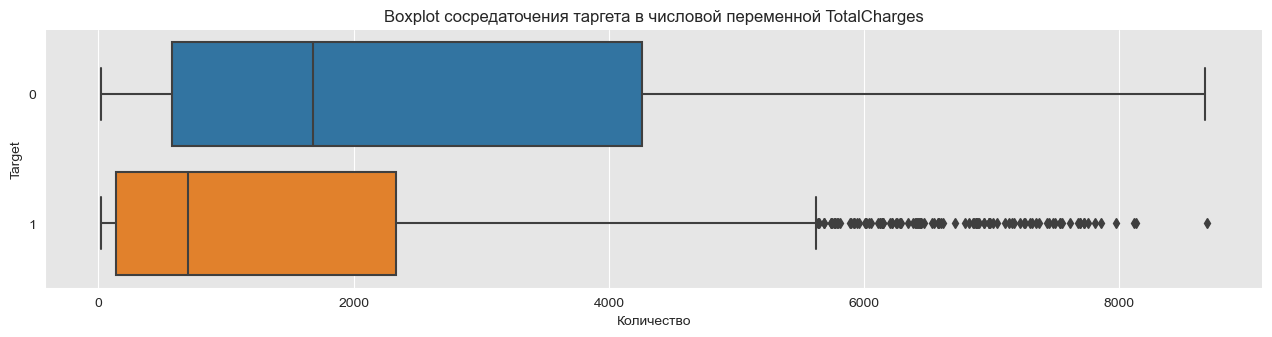

In [72]:
for i in num_col[:-1]:    
    plt.figure(figsize=(15,5))
    g = sns.catplot(y='Target', x=i, kind="box", data= data, orient='h')
    plt.title(f'Boxplot сосредаточения таргета в числовой переменной {i}')
    plt.xlabel('Количество')
    g.fig.set_figwidth(14)
    g.fig.set_figheight(3)
    plt.show();

**Вывод:**

Различие по отношению к таргету проявляется у всех признаков кроме пола клиента.

**PHIK Corr**

In [73]:
df_phik = data.copy()
df_phik = df_phik.drop(columns = ['UseServices','ServicesCount','Type_count'])
data_types = {'Type':'categoricla',
             'PaperlessBilling':'categorical',
             'PaymentMethod':'categorical',
             'MonthlyCharges':'interval',
             'TotalCharges':'interval',
             'Target':'categorical',
             'UseDay':'interval',
              'UseMonth':'interval',
             'MultipleLines':'categorical',
              'InternetService':'categorical',
              'OnlineSecurity':'categorical',
              'OnlineBackup':'categorical',
              'DeviceProtection':'categorical',
              'TechSupport':'categorical',
              'StreamingTV':'categorical',
              'StreamingMovies':'categorical',
              'gender':'categorical',
              'SeniorCitizen':'categorical',
              'Partner':'categorical',
              'Dependents':'categorical',
              'Pay_category':'categorical'}
interval_cols = [col for col, v in data_types.items() if v=='interval' and col in df_phik.columns]
interval_cols

['MonthlyCharges', 'TotalCharges', 'UseDay', 'UseMonth']

In [74]:
data_binned, binning_dict = bin_data(df_phik, cols=interval_cols, retbins=True)

In [75]:
phik_overview = df_phik.phik_matrix(interval_cols=interval_cols)

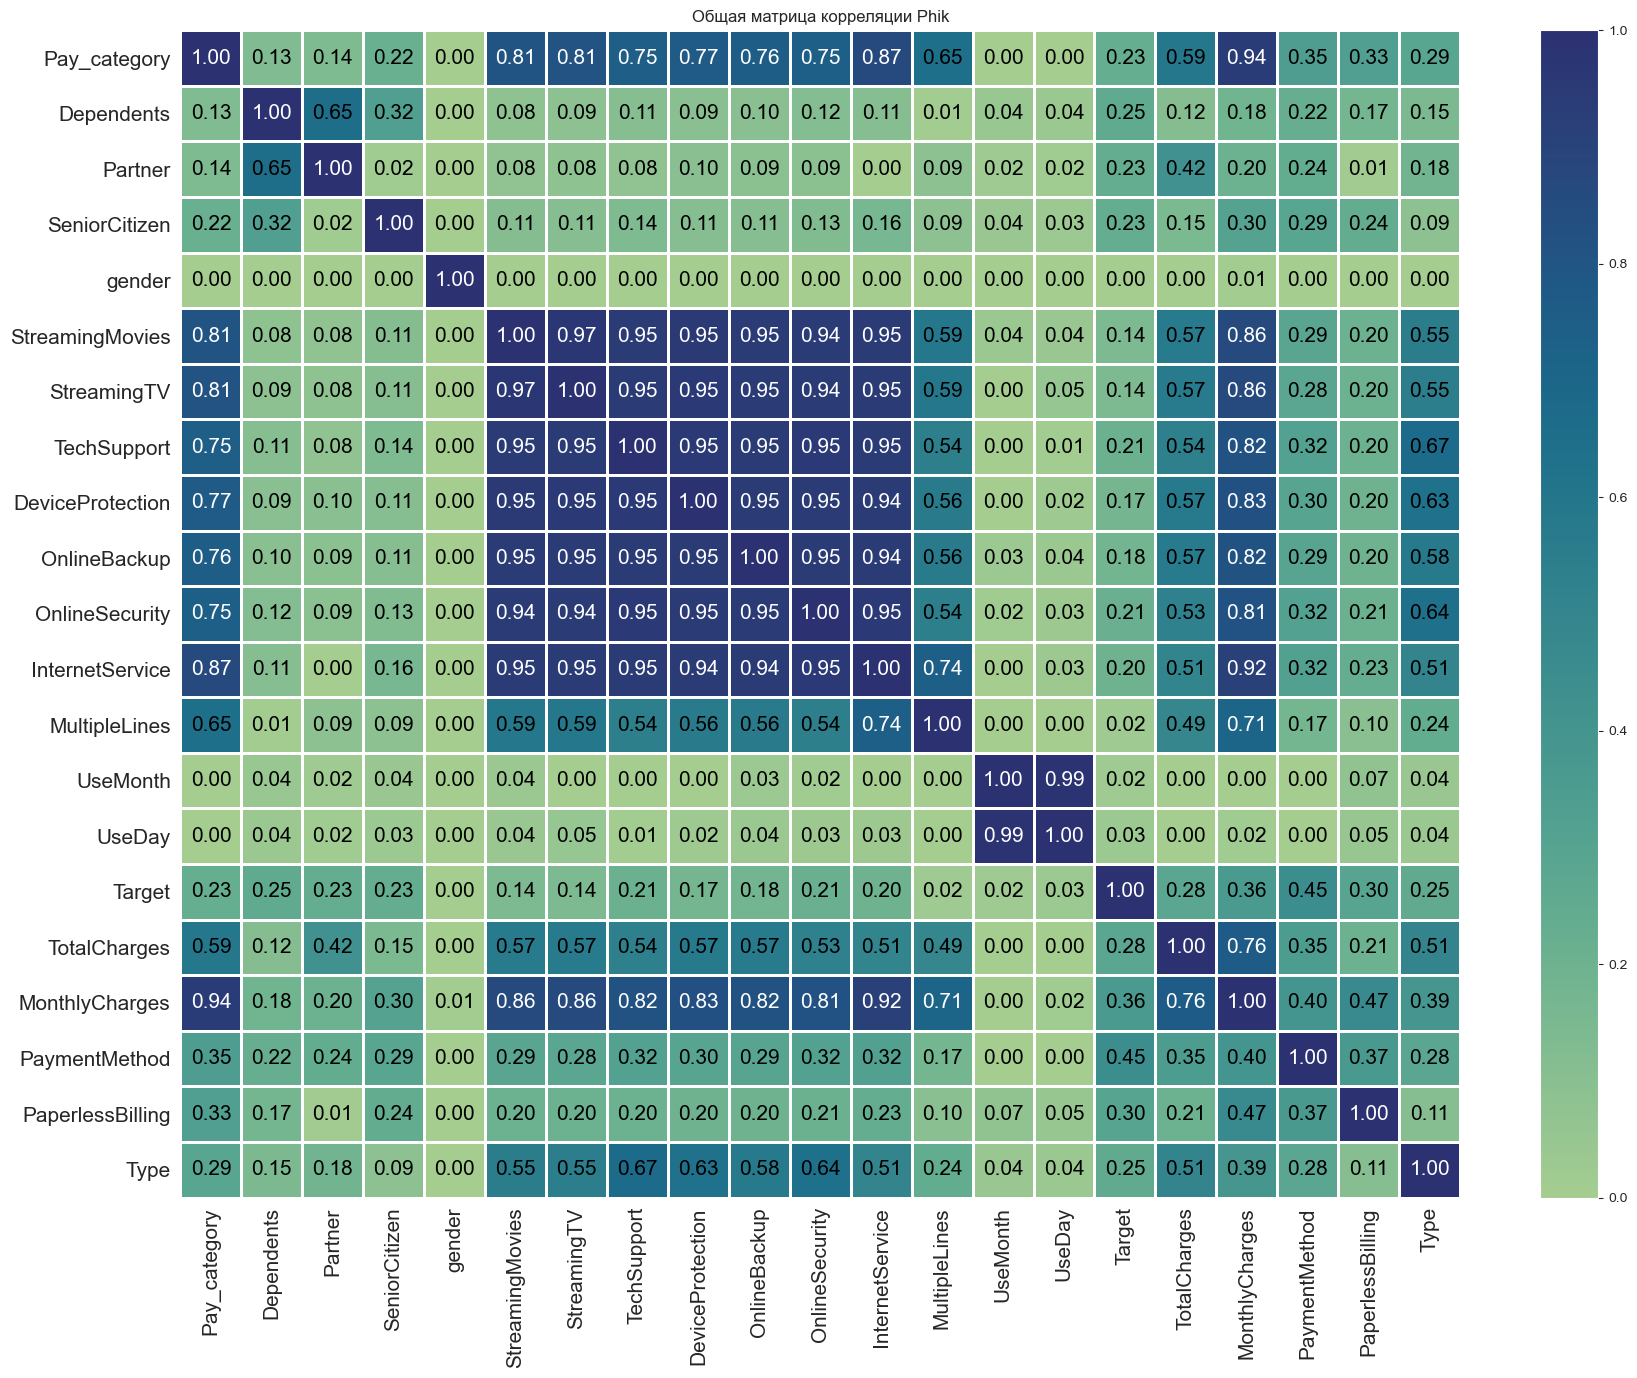

In [76]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='crest', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(18,14))
plt.tight_layout()
plt.title('Общая матрица корреляции Phik');

Text(0.5, 1.0, 'Матрица корреляции числовых переменных')

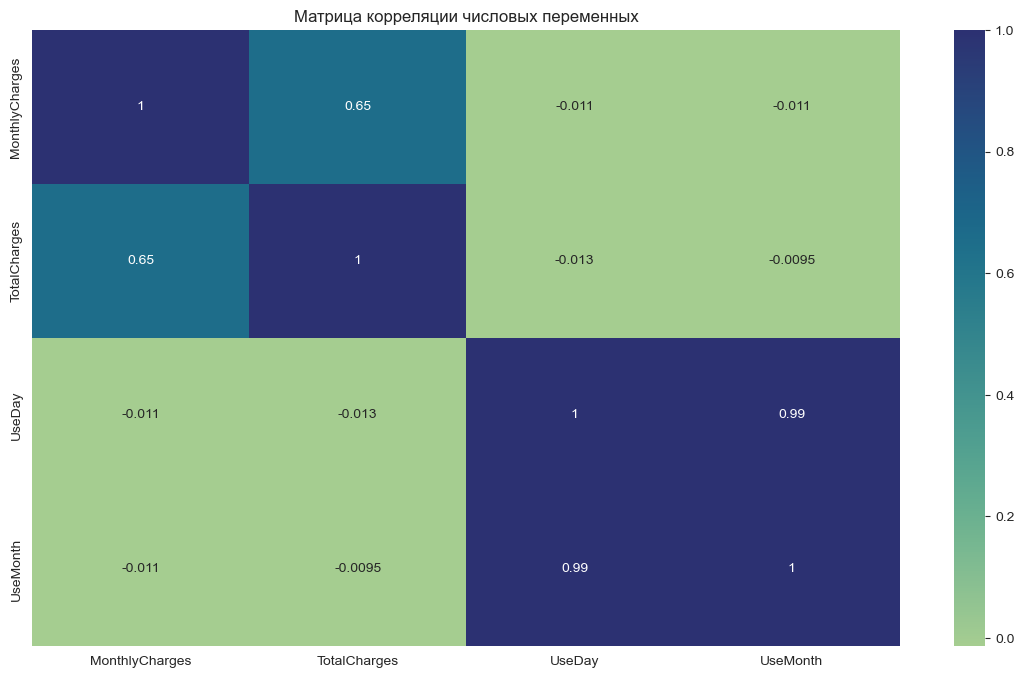

In [77]:
fig, ax = plt.subplots(figsize=(14,8)) 
sns.heatmap(data[interval_cols].corr(), annot = True, cmap="crest")
plt.title('Матрица корреляции числовых переменных')

Вывод по корреляции:
Постараемся избавиться от следующих признаков:


1. MonthlyCharges - при предположительных проблемах в точности подсчетов столбца TotalCharges, MonthlyCharget объективно более взаимосвязан с другими столбцами т.к. из них идёт его ценообразование. Плюсом - большая корреляция с TotalCharges
2. Gender - показал себя абсолютно не влияющим ни на одну переменную в наборе данных
3. UseDay & UseMonth - показали себя очень слабо в корреляции с основнм признаком. Теоретически, из-за отсутствия нормального распределения у EndDate хочется принять решение об удалении обоих признаков. Практически - удалим только один из созданных нами признаков, ввиду их полной корреляции.
4. Корреляция сервисов между собой заставляет задуматься, но мгновенного решения подобрать не могу.

**Отбор признаков**

In [79]:
data['ServicesCount'] = data['ServicesCount'].fillna(0)

In [80]:
stsc = ['UseDay','TotalCharges']
del_iter_1 = ['Type_count']
del_iter_2  =['ServicesCount', 'UseDay','MonthlyCharges']

In [81]:
ohe_col = ['PaymentMethod',
 'Type',
 'MultipleLines',
 'PaperlessBilling',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies']

drop_ohe_col_2 = [
 'UseServices']

new_cat = ['UseServices']
drop_ohe_col_1 = [ 
 'InternetService', ]

In [82]:
drop_col = list(set(data.columns) - set(ohe_col) - set(stsc))
drop_col.remove('Target')

In [83]:
for i in ohe_col:
    data[f'{i}'] = data[f'{i}'].apply(lambda x:str(x))
for i in stsc:
    data[f'{i}'] = data[f'{i}'].apply(lambda x:int(x))

In [84]:
data = data.drop(columns = drop_col)

**Создание выборок**

In [85]:
Y = data['Target']
X = data.drop(columns = ['Target'])


x_train, x_test , y_train,y_test = train_test_split(X,Y, test_size = 0.25, random_state = RANDOM_STATE)

**ColumnTransformer**

In [86]:
from sklearn.compose import ColumnTransformer
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

multicolumn_prep = ColumnTransformer([('OrdinalEncoder', 
                                       OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = 6), 
                                       ohe_col),
                                      ('StandartScaler', 
                                       StandardScaler(), 
                                       stsc),
                                     ],
                                     remainder='drop')



multicolumn_prep_ohe = ColumnTransformer([('OHE', 
                                       OneHotEncoder(handle_unknown='ignore', drop  = 'first'), 
                                       ohe_col),
                                      ('StandartScaler', 
                                       StandardScaler(), 
                                       stsc),
                                     ],
                                     remainder='drop')





multicolumn_prep

ColumnTransformer(transformers=[('OrdinalEncoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=6),
                                 ['PaymentMethod', 'Type', 'MultipleLines',
                                  'PaperlessBilling', 'SeniorCitizen',
                                  'Partner', 'Dependents', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV',
                                  'StreamingMovies']),
                                ('StandartScaler', StandardScaler(),
                                 ['UseDay', 'TotalCharges'])])

### Создание Pipeline для моделей 

LOGREG


In [87]:

log_pipeline = Pipeline([('preprocessing', multicolumn_prep_ohe),
                           ('log_model', LogisticRegression(
                                                   random_state = RANDOM_STATE,
                                                   class_weight='balanced'))])

FOREST

In [88]:
forest_pipeline = Pipeline([('preprocessing', multicolumn_prep),
                           ('forest_model', RandomForestClassifier(
                                                   random_state = RANDOM_STATE,
                                                   criterion = 'log_loss'))])

LGBM

In [89]:
lgbm_pipeline = Pipeline([('preprocessing', multicolumn_prep),
                           ('lgbm_model', LGBMClassifier(
                          random_state = RANDOM_STATE,
                           metric = 'accuracy',
                               is_higher_better = True
                      ))])

XGBOOST

In [90]:


xgb_pipeline = Pipeline([('preprocessing', multicolumn_prep),
                           ('xgb_model', XGBClassifier(
                          random_state = RANDOM_STATE,
                               eval_metric = 'auc'
                      ))])

CAT


In [91]:
cat_pipeline = Pipeline([('preprocessing', multicolumn_prep),
                           ('cat_model', CatBoostClassifier(loss_function = 'Logloss'
                                                            ,random_state = RANDOM_STATE,verbose = False)
                      )])

## Исследование моделей

Для исследование будут избранны модели ансамблей и бустинги, исключив нейронные сети ввиду малого набора данных, под который малоэффективен рост сетей вглубину. 

**Универсальные функции**

In [93]:
# вывод матрицы ошибок
def print_conf_matrix(target, predict):
    plt.figure(figsize = (8,6))
    sns.heatmap(confusion_matrix(target,predict), annot = True, fmt = 'd',
           xticklabels = ['Predicted Negative', 'Predicted Positive'],
           yticklabels = ['Ture Negative','True Positive']);
# Функция будет рисовать кривую   
def print_auc_and_acur(target, predict, predict_proba_one):
    fpr, tpr, thresholds = roc_curve(target, predict_proba_one)
    plt.figure()
    plt.plot(fpr,tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    
    auc_roc = roc_auc_score(target,predict_proba_one)
    print(f'ROC_AUC score: {auc_roc}')
    print('Accuracy score:',accuracy_score(target,predict))
    
    
# Функция будез заполнять dataframe  случшими метриками протестированных моделей:

def score_dict(model,x_features, y_target, key:str):
    predict = model.predict(x_features)
    predict_proba = model.predict_proba(x_features)
    probability = predict_proba[:,1]
    
    precision = precision_score(y_target,predict)
    accuracy = accuracy_score(y_target,predict)
    recall = recall_score(y_target,predict)
    roc_auc = roc_auc_score(y_target,probability)
    best_score = model.best_score_
    
    return_dict = pd.DataFrame({key:[precision,accuracy,recall,roc_auc,best_score]},
                               index = ['precision','accuracy','recall','ROC AUC','CV_score'])
    return return_dict
    

### LogisticRegression

In [94]:
gscv_log = GridSearchCV(estimator = log_pipeline,
                        cv = skf,
                        scoring=['roc_auc'], refit='roc_auc' ,
                        verbose=0,
                        param_grid = {'log_model__C':[0.1,0.2,0.5,0.8]},
                       )
gscv_log.fit(x_train,y_train)
print(gscv_log.best_estimator_)
log = gscv_log.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('OHE',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['PaymentMethod', 'Type',
                                                   'MultipleLines',
                                                   'PaperlessBilling',
                                                   'SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies']),
                      

In [95]:
print('Лучшая точность на кросс-валидации:',gscv_log.best_score_)


Лучшая точность на кросс-валидации: 0.8250268419981682


ROC_AUC score: 0.8300794948329742
Accuracy score: 0.7258614161302537


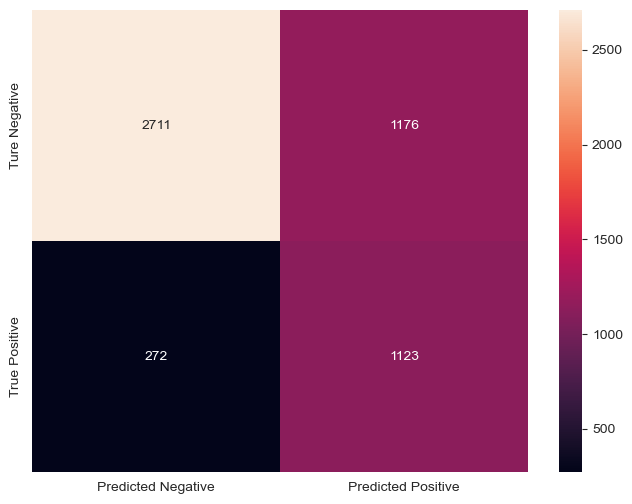

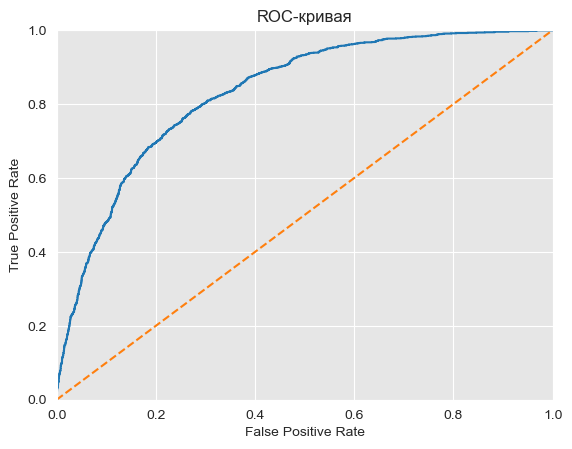

In [96]:
print_conf_matrix(y_train,log.predict(x_train))
print_auc_and_acur(y_train, log.predict(x_train),log.predict_proba(x_train)[:,1])

In [97]:
final_table_train = score_dict(gscv_log,x_train,y_train,'LogReg Train')

### RandomForestClassifier

In [98]:
gscv_forest = GridSearchCV(estimator = forest_pipeline,
                        cv = skf,
                        scoring=['roc_auc'], refit='roc_auc' ,
                        verbose=0,
                        param_grid = {'forest_model__n_estimators':[50,100,300,800],
                                      'forest_model__max_depth':[5,7,8,12],
                                      'forest_model__min_samples_leaf':[2,4,6,20]},
                       )
gscv_forest.fit(x_train,y_train)
print(gscv_forest.best_estimator_)
forest = gscv_forest.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('OrdinalEncoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=6),
                                                  ['PaymentMethod', 'Type',
                                                   'MultipleLines',
                                                   'PaperlessBilling',
                                                   'SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies

In [99]:
print('Лучшая точность на кросс-валидации:',gscv_forest.best_score_)

Лучшая точность на кросс-валидации: 0.8295843110135225


ROC_AUC score: 0.8676172666354995
Accuracy score: 0.8157894736842105


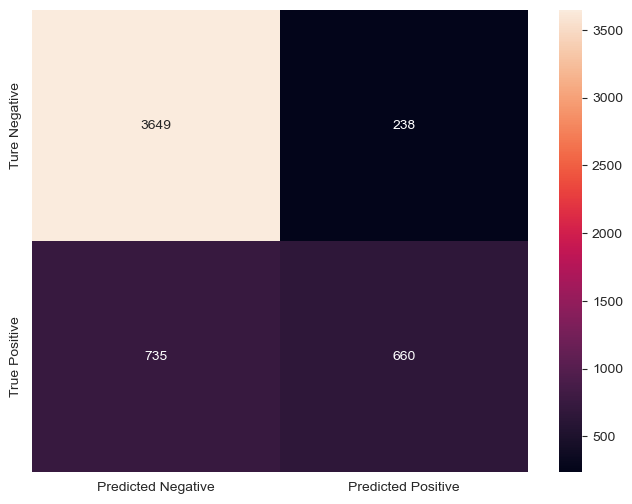

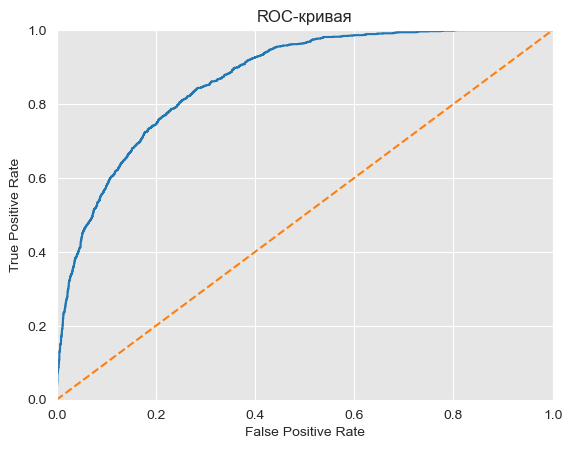

In [100]:
print_conf_matrix(y_train,forest.predict(x_train))
print_auc_and_acur(y_train, forest.predict(x_train),forest.predict_proba(x_train)[:,1])

In [101]:
final_table_train = final_table_train.join(score_dict(gscv_forest,x_train,y_train,'RandomForest Train'))

#### LGBMClassifier

In [102]:
gscv_lgbm = GridSearchCV(estimator = lgbm_pipeline,
                        cv = skf,
                        scoring=['roc_auc'], refit='roc_auc' ,
                        verbose=0,
                        param_grid = {'lgbm_model__learning_rate':[0.001,0.025,0.05,0.1,0.2],
                                       'lgbm_model__n_estimators':[100,128,300,600,1000],
                                       'lgbm_model__num_leaves':[2,4,6,8,10],
                                       'lgbm_model__max_bin':[510,700,900]},
                       )
gscv_lgbm.fit(x_train,y_train)
print(gscv_lgbm.best_estimator_)
lgbm = gscv_lgbm.best_estimator_

[LightGBM] [Warning] Unknown parameter: is_higher_better
[LightGBM] [Warning] Unknown parameter: is_higher_better
[LightGBM] [Info] Number of positive: 930, number of negative: 2591
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 904
[LightGBM] [Info] Number of data points in the train set: 3521, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.264130 -> initscore=-1.024615
[LightGBM] [Info] Start training from score -1.024615
[LightGBM] [Warning] Unknown parameter: is_higher_better
[LightGBM] [Warning] Unknown parameter: is_higher_better
[LightGBM] [Warning] Unknown parameter: is_higher_better
[LightGBM] [Info] Number of positive: 930, number of negative: 2591
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000158

In [103]:
print('Лучшая точность на кросс-валидации:',gscv_lgbm.best_score_)

Лучшая точность на кросс-валидации: 0.8387316401996808


[LightGBM] [Warning] Unknown parameter: is_higher_better
[LightGBM] [Warning] Unknown parameter: is_higher_better
[LightGBM] [Warning] Unknown parameter: is_higher_better
ROC_AUC score: 0.8494310139579316
Accuracy score: 0.8089738735327527


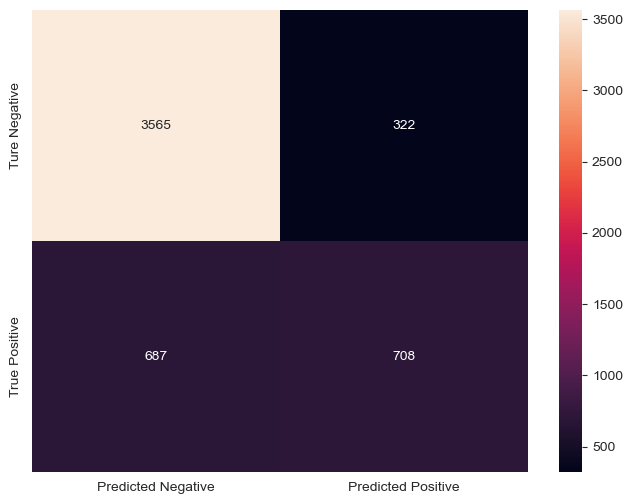

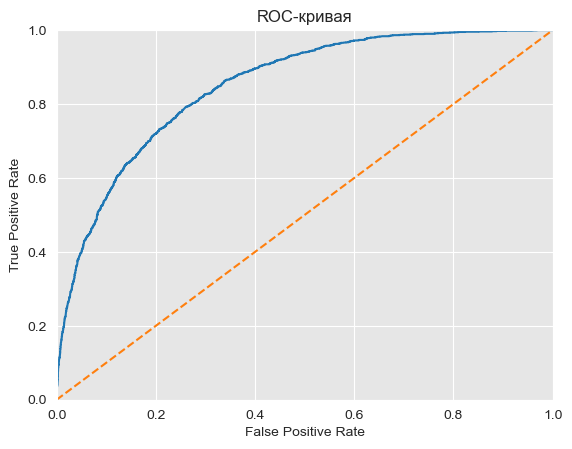

In [104]:
print_conf_matrix(y_train,lgbm.predict(x_train))
print_auc_and_acur(y_train, lgbm.predict(x_train),lgbm.predict_proba(x_train)[:,1])

In [105]:
final_table_train = final_table_train.join(score_dict(gscv_lgbm,x_train,y_train,'LGBMClassifier Train'))

[LightGBM] [Warning] Unknown parameter: is_higher_better
[LightGBM] [Warning] Unknown parameter: is_higher_better


### CatBoostClassifier

In [106]:
gscv_cat = GridSearchCV(estimator = cat_pipeline,
                        cv = skf,
                        scoring=['roc_auc', 'accuracy'], refit='roc_auc' ,
                        verbose=0,
                        param_grid = {'cat_model__learning_rate':[0.001,0.1,0.5],
                                                       'cat_model__depth':[2,4,8,12],
                                                       'cat_model__n_estimators':[50,150,450,1000]},
                       )
gscv_cat.fit(x_train,y_train)
print(gscv_cat.best_estimator_)
cat = gscv_cat.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('OrdinalEncoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=6),
                                                  ['PaymentMethod', 'Type',
                                                   'MultipleLines',
                                                   'PaperlessBilling',
                                                   'SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies

In [107]:
print('Лучшая точность на кросс-валидации:',gscv_cat.best_score_)

Лучшая точность на кросс-валидации: 0.8352485011893614


ROC_AUC score: 0.8480421365953785
Accuracy score: 0.8049981067777358


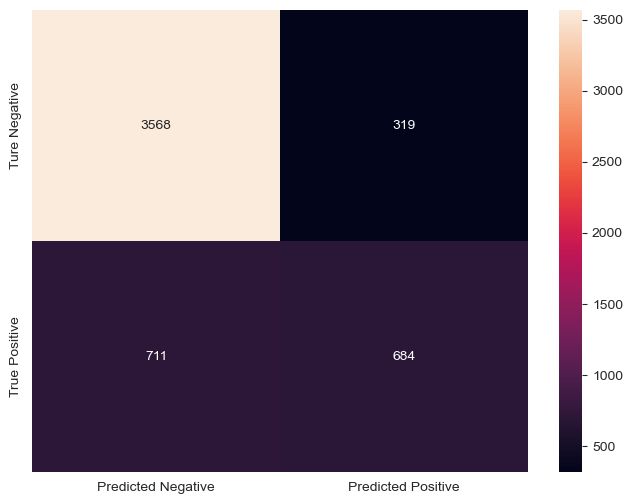

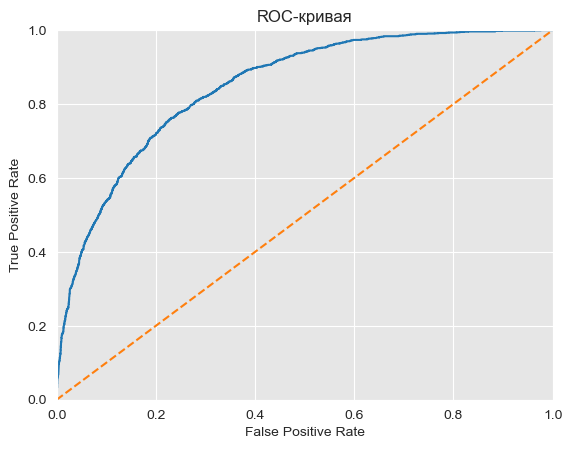

In [108]:
print_conf_matrix(y_train,cat.predict(x_train))
print_auc_and_acur(y_train, cat.predict(x_train),cat.predict_proba(x_train)[:,1])

In [109]:
final_table_train = final_table_train.join(score_dict(gscv_cat,x_train,y_train,'CatBoostClassifier Train'))

### XGBoost

In [110]:
gscv_xgb = GridSearchCV(estimator = xgb_pipeline,
                        cv = skf,
                        scoring=['roc_auc', 'accuracy'], refit='roc_auc' ,
                        verbose=0,
                        param_grid = {
                    "xgb_model__max_depth":[2, 4, 6, 12, 15],
                    "xgb_model__min_child_weight":[2,5,15],
                    "xgb_model__learning_rate":[0.3, 0.1, 0.03],
                    "xgb_model__n_estimators":[100,150,200,600,1000]},
                       )
gscv_xgb.fit(x_train,y_train)
print(gscv_xgb.best_estimator_)
xgb = gscv_xgb.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('OrdinalEncoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=6),
                                                  ['PaymentMethod', 'Type',
                                                   'MultipleLines',
                                                   'PaperlessBilling',
                                                   'SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies

In [111]:
print('Лучшая точность на кросс-валидации:',gscv_xgb.best_score_)

Лучшая точность на кросс-валидации: 0.8356709470180199


ROC_AUC score: 0.8500760277111555
Accuracy score: 0.8082165846270352


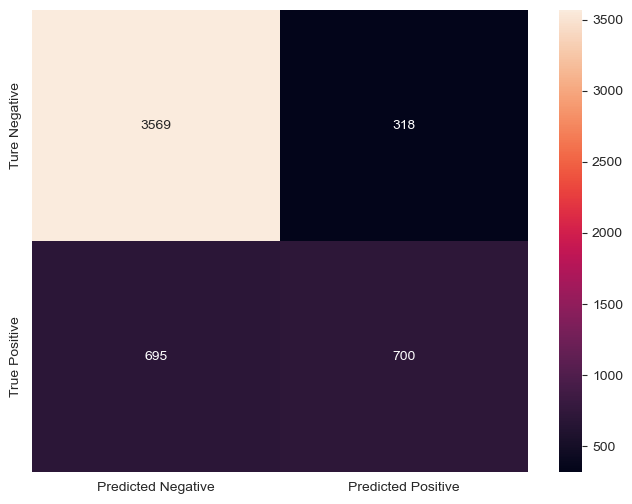

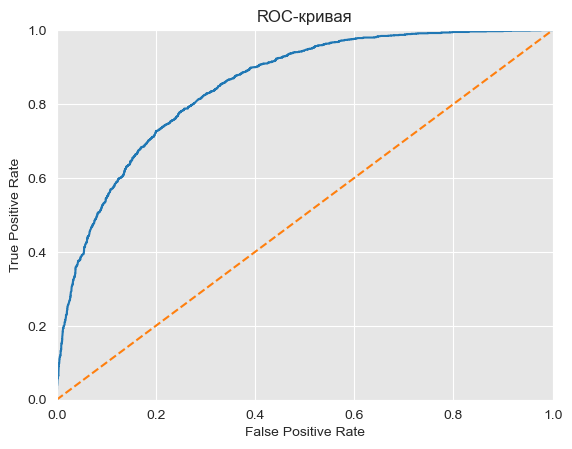

In [112]:
print_conf_matrix(y_train,xgb.predict(x_train))
print_auc_and_acur(y_train, xgb.predict(x_train),xgb.predict_proba(x_train)[:,1])

In [113]:
final_table_train = final_table_train.join(score_dict(gscv_xgb,x_train,y_train,'XGBClassifier Train'))

## Сравнение и выбор итоговой модели:

**ROC-AUC:**

In [115]:
color_list = ['seagreen','teal','peru','black','olive']

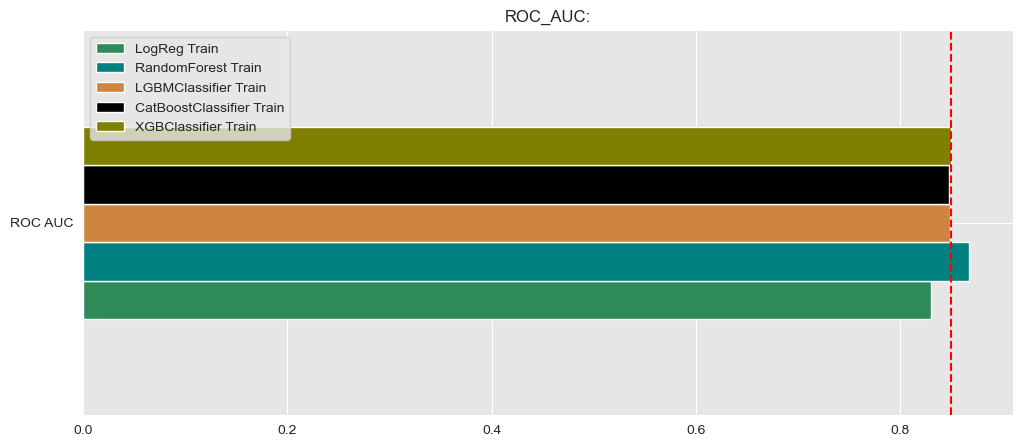

,LogReg Train,RandomForest Train,LGBMClassifier Train,CatBoostClassifier Train,XGBClassifier Train
ROC AUC,0.830079,0.867617,0.849431,0.848042,0.850076


In [116]:
final_table_train[3:4].plot(kind = 'barh', color = color_list, figsize = [12,5])
plt.axvline(x = 0.85, color = 'r', linestyle = '--')
plt.title('ROC_AUC:')
plt.show()
display(final_table_train[3:4])

**BEST SCORE моделей на Кросс-валидации | ЦЕЛЕВОЙ ПОКАЗАТЕЛЬ**

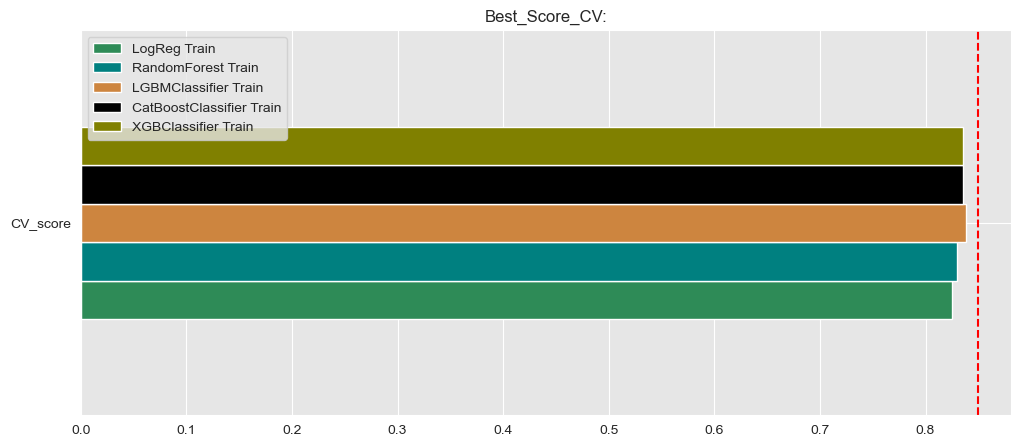

,LogReg Train,RandomForest Train,LGBMClassifier Train,CatBoostClassifier Train,XGBClassifier Train
CV_score,0.825027,0.829584,0.838732,0.835249,0.835671


In [117]:
final_table_train[4:].plot(kind = 'barh', color = color_list, figsize = [12,5])
plt.axvline(x = 0.85, color = 'r', linestyle = '--')
plt.title('Best_Score_CV:')
plt.show()
display(final_table_train[4:])

Среди всех моделей, с незначительным отрывом, побеждает LGBMClassifier.
Однако, по метрике на кросс валидации можно предполагать не достигнотую на Обучени точность и на тесте.

**Площадь под кривой:**

[LightGBM] [Warning] Unknown parameter: is_higher_better


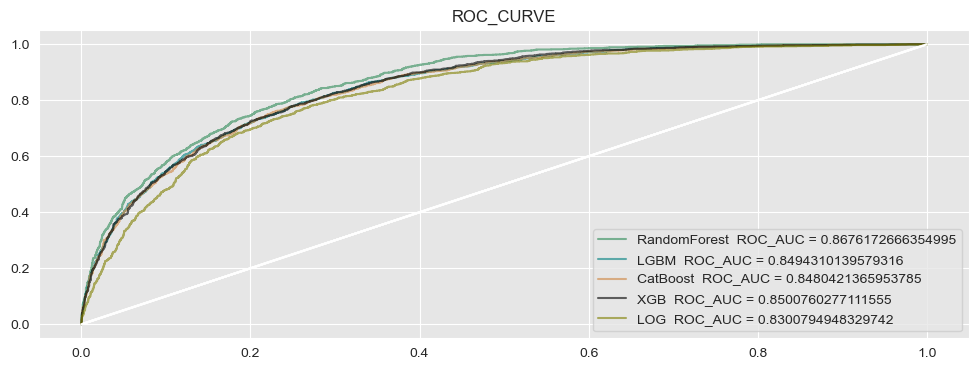

In [118]:
model_list = [forest,lgbm,cat,xgb,log]
model_name = ['RandomForest', 'LGBM', 'CatBoost', 'XGB','LOG']
plt.figure(figsize = [12,4])
for i,m in zip(model_list,range(len(model_list))):
    predict_proba = i.predict_proba(x_train)[:,1]

    fpr,tpr, thresholds = roc_curve(y_train,predict_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr, label = f'{model_name[m]}  ROC_AUC = {roc_auc}',alpha = 0.6, color = color_list[m])
    plt.plot([0,1],[0,1], color = 'white')
plt.legend(loc = 'best')
plt.title('ROC_CURVE')
plt.show()

Не смотря на явного победителя по ROC_CURVE, в данном наборе данных мы придерживаемся задания - выбирать модель по точности на Кросс-валидации, которая лучше позволяет избежать случайных, более позитивных исходов в показателях score.

### Выбор модели:

Все моедли показали сравнительно идентичную точности, где с небольшим отрывом в лидеры вышла LGBMClassifier.

In [119]:
gscv_lgbm.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('OrdinalEncoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=6),
                                                  ['PaymentMethod', 'Type',
                                                   'MultipleLines',
                                                   'PaperlessBilling',
                                                   'SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies']),
                                                 ('StandartScaler',
                                                  StandardScaler(),
                                                  ['UseDay',
                                                   'TotalCharges'])])),
                ('lgbm_model',
                 LGBMClassifier(is_higher_better=True, max_bin=510,
                                metric='accuracy', n_estimators=600,
                                num_leaves=2, random_state=160424))])

Повторим преобразования, которые использовались в Pipeline, только для одиночной, избранной модели.
Это позволит лучше интерпретировать признаки модели, через специальную библиотеку для интерпритации бустингов.

In [120]:
ordEn = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = 6)
ordEn.fit(x_train[ohe_col])
x_train[ohe_col] = ordEn.transform(x_train[ohe_col])
x_test[ohe_col] = ordEn.transform(x_test[ohe_col])

In [121]:
mas = StandardScaler()
mas.fit(x_train[stsc])
x_train[stsc] = mas.transform(x_train[stsc])
x_test[stsc] = mas.transform(x_test[stsc])

In [122]:
lgbm =  LGBMClassifier(is_higher_better=True, max_bin=510, metric='accuracy',
               n_estimators=600, num_leaves=2, random_state=160424)
lgbm.fit(x_train,y_train)

[LightGBM] [Warning] Unknown parameter: is_higher_better
[LightGBM] [Warning] Unknown parameter: is_higher_better
[LightGBM] [Info] Number of positive: 1395, number of negative: 3887
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 934
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.264105 -> initscore=-1.024743
[LightGBM] [Info] Start training from score -1.024743


LGBMClassifier(is_higher_better=True, max_bin=510, metric='accuracy',
               n_estimators=600, num_leaves=2, random_state=160424)

**Матрица ошибок для выбранной модели:**

[LightGBM] [Warning] Unknown parameter: is_higher_better
[LightGBM] [Warning] Unknown parameter: is_higher_better
ROC_AUC score: 0.8425089912431685
Accuracy score: 0.794434980124929


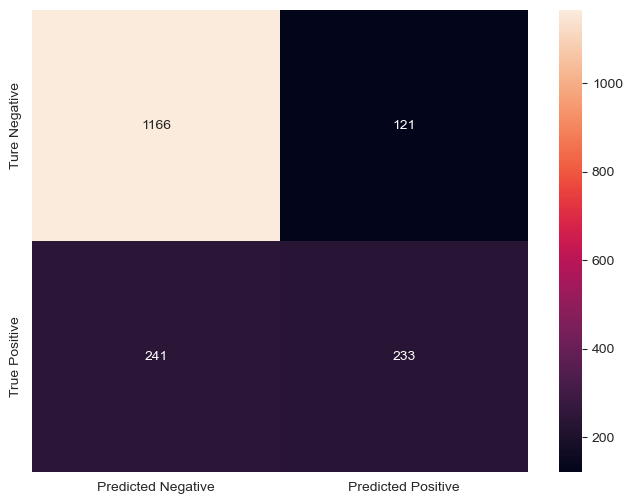

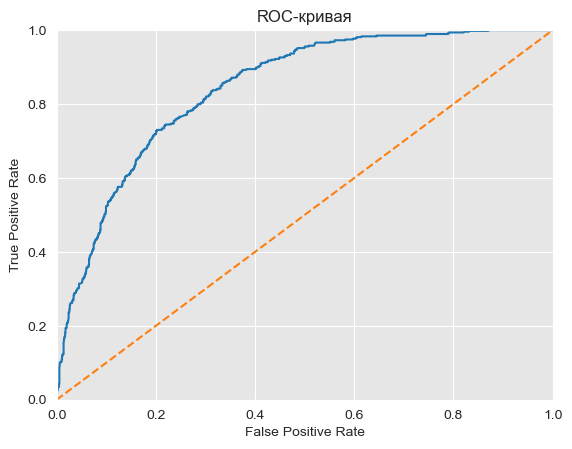

In [123]:
x = lgbm.predict_proba(x_test)[:,1]
v = lgbm.predict(x_test)
print_conf_matrix(y_test,v)
print_auc_and_acur(y_test,v, x)

Метрики эффективности модели:

Модель показывает большую точность, что обусловленно большим количеством правильно предсказанных, оставшихся, клиентов.

В определении конкретно целевого признака - уходящего клиента, модель справляется значительно хуже, затрагивая чуть меньше половины их реального количества.

В то же время ~ 35% от всех предсказанных моделью, уходящих, клиентов - не являются таковыми и предпочли бы продолжать пользоваться услугами компании.

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> 
    К сожалению, на тесте, модель не смогла побить порог ROC_AUC > 0.85. Мне нехватило понимания для обработки признаков под этот dataset. Думаю, за успех в прошлый раз отвечала утечка при кодировании и, возможно, объем обучающей выборки. Как не хватит времени успеть к концу этого, жестокого, дедлайна.

</div>

## Feature Importance

Извлечем важность признаков с модели, показавшей лучшую точность на целевой метрике:

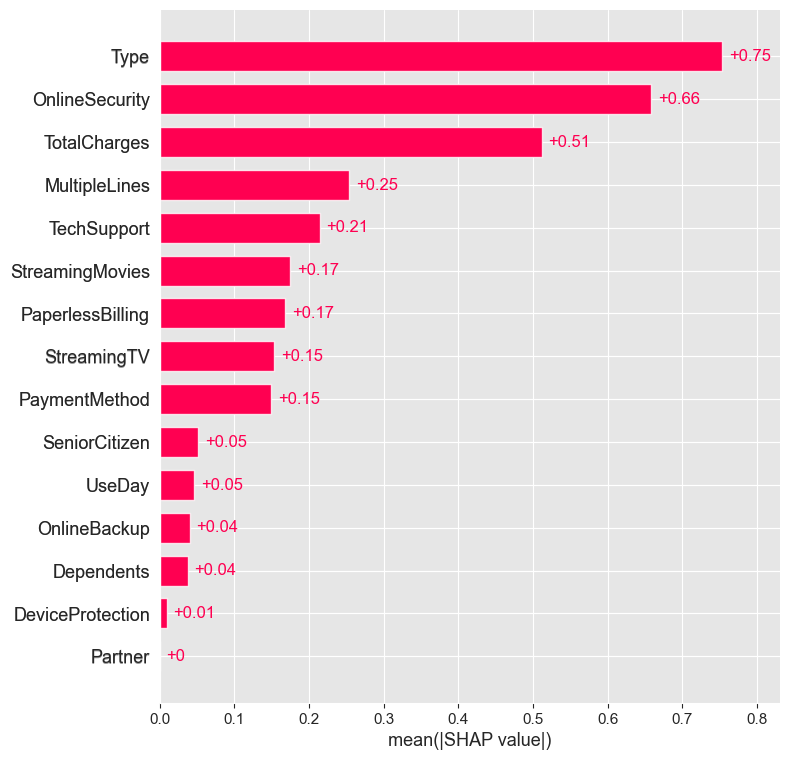

In [124]:
explainer = shap.Explainer(lgbm)
shap_values = explainer(pd.DataFrame(x_test, columns = data.drop(columns = ['Target']).columns))
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize = (12,6))

shap.plots.bar(shap_values[:,:,1], max_display = pd.DataFrame(x_test, columns = data.drop(columns = ['Target']).columns).shape[0])

* Лидирующая тройка:
      
      Тип оплаты,в месяц, год, или два года,
      Использование Антивируса,
      И Общий объем денег переданных компаниии за услуги.
      
* Вторые по значимости признаки связаны с использованием дополнительных услуг клиентом:
      
      Интернет сервисы
      И Мульти-телефонная линия
      
* Наименьшую долю в предсказание вносят:
    
      Личные характеристики клиента
      И срок заключения контракта
       

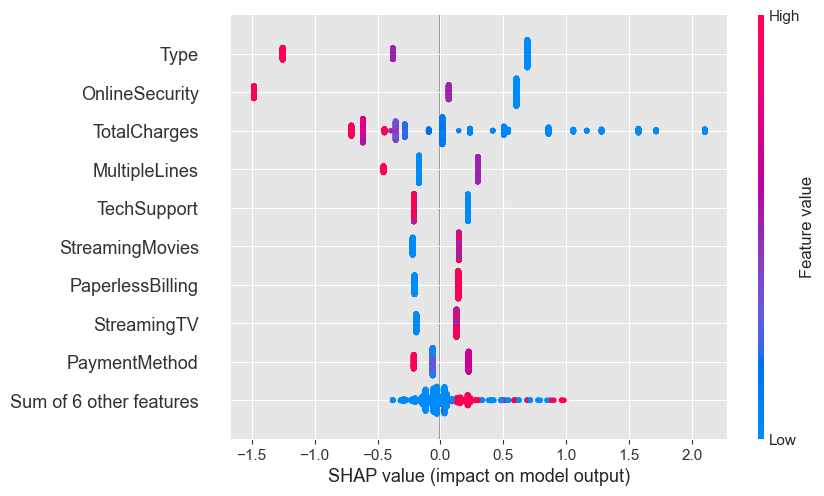

In [125]:
shap.plots.beeswarm(shap_values[:,:,1])

* Влияение лидирующей тройки признаков на тональность предсказания:

        Клиенты оплачивающие тарифы компании на дольгое время(не на месяц) желательнее продолжают пользоваться услугами.
        Наличие антивируса значительно влияет на поведение клиента.
        Чем больше клиент, суммарно, перевел компании за время действия договора с ней тем больше его решение продолжать пользоваться услугами далее.

## Итоговый вывод:

1. Лучшей моделью для выполнения поставленной задачи: "Предсказание разрыва контракта с клиентом" стала LGBMClassifier со следующим набором гипперпараметров: 

            * is_higher_better=True,
            * max_bin=510,
            * metric='accuracy',
            * n_estimators=600, 
            * num_leaves=2, 
            * random_state=160424
 
 
2. Лучшая по Best_score на валидации модель показала следующую точность:

        * Точность модели 'по' кривой ROC_AUC на Обучающей выборке составила: 0.849431, не привысив заказанный порог.
        * Точность модели 'по' кривой ROC_AUC на Тестовой выборке составила: 0.842, не превысив заказанный порог.

 

3. Остальные точности позволяют рассказать о модели следующее: Модель обладает большой точностью, но ограниченной в классе предсказаний остающихся клиентов. Модель способна определить ~50% клиентов относящихся к уходящему классу, притом, что на 100 истинно предсказанных, уходящих клиентов, придётся 35 не правильно предсказанных клиентов, собирающихся остаться, а не уходить.

* Основная задача не выполнена и метрика не достигнута.

**Дополнительная информация по анализу признаков влияющих на предсказание модели:**

1. Модель прослеживает прямую зависимость между желанием у клиента расторгнуть контракт и увеличением месячной платы.
2. Для клиента важен тип подключения( подключение по оптоволокну дает куда больший отток), и возможность разово оплачивать услуги на большой срок.
3. Время расторжения контракта, вероятно, собранно не корректо, что не позволяет изучить реальное его влияние.


